In [7]:
import numpy as np
import nibabel as nib
from scipy.signal import butter, filtfilt, hilbert
import matplotlib.pyplot as plt
%matplotlib inline
subjects = np.loadtxt('../100unrelatedsubjectsIDs.txt', dtype='str')
p = 116
K = 3

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="bandpass")
    return b, a

# Apply Filter
# Changed by Anders to be correct range (from 0.01-0.1 to 0.009-0.08)
def butter_bandpass_filter(data, lowcut=0.009, highcut=0.08, fs=1 / 0.720, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [9]:
atlas = nib.load('../data/external/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii')
atlas_data = atlas.get_fdata()
atlas_data = np.round(atlas_data)
atlas_data = atlas_data.astype(int)[0]
filtered_data_all = []

for sub in subjects[:1]:
    img = nib.load('../data/raw/'+sub+'/fMRI/rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii')
    data = img.get_fdata()
    data = data - np.mean(data, axis=0)
    # parcellate data in atlas
    parcellated_data = np.zeros((data.shape[0], atlas_data.max()))
    for i in range(1, atlas_data.max()+1):
        parcellated_data[:,i-1] = np.mean(data[:,atlas_data == i], axis=1)
    # filter data
    filtered_data = np.zeros(parcellated_data.shape)
    for i in range(p):
        filtered_data[:,i] = butter_bandpass_filter(parcellated_data[:,i])
    filtered_data_all.append(filtered_data)
    

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [10]:
phase_randomized_data_all = []
for sub in range(1):
    phase_randomized_data = np.zeros(filtered_data_all[sub].shape)
    # add random phase to each time-series
    phase = np.random.rand(p)*2*np.pi
    for i in range(p):
        # frequency domain
        tmp = np.fft.fft(filtered_data_all[sub][:,i])
        # add phase
        tmp = tmp * np.exp(1j*phase[i])
        # back to time-domain
        phase_randomized_data[:,i] = np.real(np.fft.ifft(tmp))
    phase_randomized_data_all.append(phase_randomized_data)

In [11]:
#establish Sigma matrix
S1 = 0.1*np.ones((p,p))
S1[:38,:38] = 0.9
S1 = S1 - np.diag(np.diag(S1))
S1 = S1 + np.eye(p)
S2 = 0.1*np.ones((p,p))
S2[38:76,38:76] = 0.9
S2 = S2 - np.diag(np.diag(S2))
S2 = S2 + np.eye(p)
S3 = 0.1*np.ones((p,p))
S3[76:,76:] = 0.9
S3 = S3 - np.diag(np.diag(S3))
S3 = S3 + np.eye(p)

/tmp/ipykernel_2612353/917374543.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  filtered_noise_data2[:,i] = np.abs(hilbert(filtered_noise_data[:,i])) * np.exp(1j*phase_data)


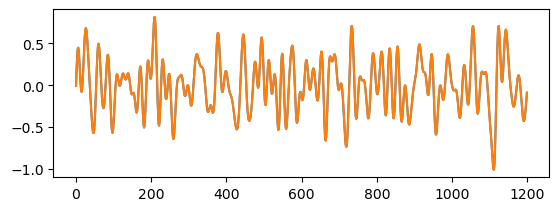

In [12]:
# make random gaussian noise data
noise_data = np.random.normal(0,1,filtered_data_all[0].shape)
#filter data
filtered_noise_data = np.zeros(noise_data.shape)
for i in range(p):
    filtered_noise_data[:,i] = butter_bandpass_filter(noise_data[:,i])

#manually set the phase information in all signals to zero
filtered_noise_data2 = np.zeros(filtered_noise_data.shape)
for i in range(p):
    phase_data = np.angle(hilbert(filtered_noise_data[:,i]))
    filtered_noise_data2[:,i] = np.abs(hilbert(filtered_noise_data[:,i])) * np.exp(1j*phase_data)
    # to time-domain
    # filtered_noise_data2[:,i] = np.real(np.fft.ifft(filtered_noise_data2[:,i]))

plt.subplot(2,1,1)
plt.plot(filtered_noise_data[:,0])
plt.plot(filtered_noise_data2[:,0])

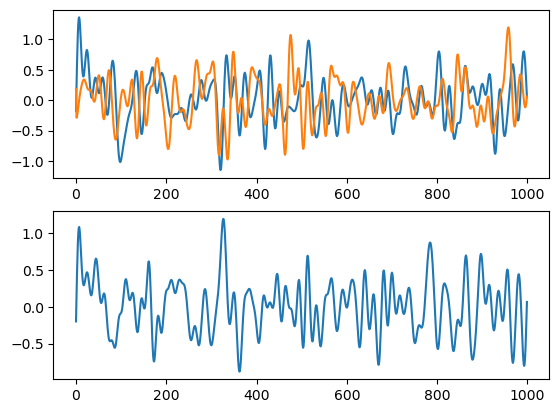

In [13]:
# generate some synthetic data, bandpass filter, convert to frequency domain, set all phases to zero, convert back to time-domain
synthetic_data = np.random.normal(0,1,(1000,p))
filtered_synthetic_data = np.zeros(synthetic_data.shape)
for i in range(p):
    filtered_synthetic_data[:,i] = butter_bandpass_filter(synthetic_data[:,i])

signal1_filtered = filtered_synthetic_data[:,0]
signal2_filtered = filtered_synthetic_data[:,1]
tmp1 = np.fft.fft(signal1_filtered)
tmp2 = np.fft.fft(signal2_filtered)
phase_diff = np.angle(tmp1) - np.angle(tmp2)
#apply phase difference to spectrum 2
# tmp2 = np.abs(tmp2) * np.exp(1j*(np.angle(tmp1)))
tmp2 = np.abs(tmp2) * np.exp(1j*(phase_diff))
#back to time-domain
signal2_filtered_phasesignal1 = np.real(np.fft.ifft(tmp2))
plt.subplot(2,1,1)
plt.plot(signal1_filtered)
plt.plot(signal2_filtered_phasesignal1)
plt.subplot(2,1,2)
plt.plot(signal2_filtered)
plt.show()